In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Lambda, Conv1D, Activation
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from model_util.losses import get_fractional_loss, get_unit_bet_loss

In [2]:
# Load validation data
save_path = "data/validation_data/"
X_train = np.load(save_path + "X_train.npy")
Y_train = np.load(save_path + "Y_train.npy")
X_test = np.load(save_path + "X_test.npy")
Y_test = np.load(save_path + "Y_test.npy")
X_val = np.load(save_path + "X_val.npy")
Y_val = np.load(save_path + "Y_val.npy")

# Define odds inputs
O_train, O_test, O_val = Y_train[:, 1:], Y_test[:, 1:], Y_val[:, 1:]
scaler = StandardScaler()
O_train = scaler.fit_transform(O_train)
O_test = scaler.transform(O_test)
O_val = scaler.transform(O_val)

In [3]:
# Load in pretrained win-loss models
wl_models = [load_model(f"saved_models/win_loss_model/model_{i}") for i in range(9)]

# Build an averaging model
wl_input = Input(shape=(X_train.shape[1]))
wl_outputs = [m(wl_input) for m in wl_models]
avg_wl_output = tf.keras.layers.Average()(wl_outputs)

avg_wl_model = Model(inputs=wl_input, outputs=avg_wl_output, name="wl_avg_model")
avg_wl_model.trainable = False

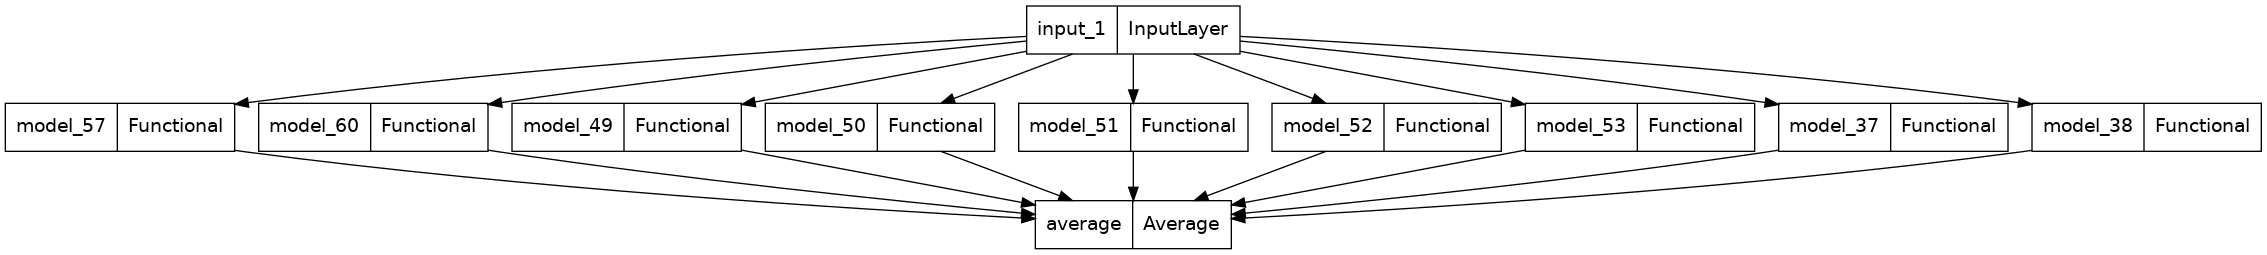

In [4]:
tf.keras.utils.plot_model(avg_wl_model, to_file='model_images/avg_wl_model.png')

In [5]:
epochs = 400
learning_rate = 1e-4
learning_rate_decay = 0 # learning_rate / 100
batch_size = 16
n_models = 13
regularizer = tf.keras.regularizers.L1(l1=0.005)

loss = get_unit_bet_loss(batch_size=batch_size, day_bet_num=1)

In [6]:
# Define the kelly function
def tf_kelly(layer):
    # Split the layer
    home_win, home_o, away_o = tf.split(layer, [1,1,1], 1)
    away_win = 1 - home_win
    # Do the calculations
    home_frac = ((home_o-1)*home_win - away_win)/(home_o-1)
    away_frac = ((away_o-1)*away_win - home_win)/(away_o-1)
    # Return the layer
    return Concatenate()([home_frac, away_frac])

In [7]:
# Make the model
main_input = Input(shape=(X_train.shape[1]), name="main_input")
odds_input = Input(shape=(2), name="odds_input")

odds_concat = Concatenate(name="main_odds_input")([main_input, odds_input])

# Define the main branch
hidden_layer = Dense(10, activation="relu", kernel_regularizer=regularizer, name="main_odds_hl_1")(odds_concat)

# Define the wl branch
wl_output = avg_wl_model(main_input)

# Do a kelly transformation
kelly_layer = Concatenate(name="wl_output_odds")([wl_output, odds_input])
kelly_layer = Lambda(tf_kelly, name='kelly_fn')(kelly_layer)

# Append output to averaging model
concat_layer = Concatenate(name="summary_layer")([hidden_layer, wl_output, kelly_layer, odds_input])
hidden_layer_2 = Dense(5, activation="relu", kernel_regularizer=regularizer, name="summary_hl_1")(concat_layer)
output_layer = Dense(2, activation="sigmoid", name="output")(hidden_layer_2)

# Define the model object
model = Model(inputs=[main_input, odds_input], outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=learning_rate_decay)
model.compile(loss=loss, optimizer=optimizer)

model.summary()
tf.keras.utils.plot_model(model, to_file='model_images/betting_model.png')

TypeError: list indices must be integers or slices, not str

In [ ]:
train_input, val_input = [X_train, O_train], [X_val, O_val]
history = model.fit(x=train_input, y=Y_train, validation_data=(val_input, Y_val), 
                    batch_size=batch_size, epochs=epochs, verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
def betting_sim(preds, true):
    won, home_odds, away_odds = true[:, 0], true[:, 1], true[:, 2]
    
    bankroll = [100]
    unit_size = 10
    for i in range(len(preds)):
        
        if preds[i,1] < 0.5:
            bankroll.append(bankroll[-1])
            continue
        
        if preds[i, 0] > 0.5:
            # We want to bet home
            bet_won, bet_odds = won[i] == True, home_odds[i]
        else:
            # We want to bet away
            bet_won, bet_odds = won[i] == False, away_odds[i]
            
        if bet_won: 
            bankroll.append(bankroll[-1] + unit_size*(bet_odds - 1))
        else:
            bankroll.append(bankroll[-1] - unit_size)
            
    return bankroll

train_preds, test_preds, val_preds = model.predict(X_train), model.predict(X_test), model.predict(X_val)

bankroll = betting_sim(train_preds, Y_train)
plt.plot(bankroll)
plt.show()

bankroll = betting_sim(test_preds, Y_test)
plt.plot(bankroll)
plt.show()

bankroll = betting_sim(val_preds, Y_val)
plt.plot(bankroll)
plt.show()